In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import editdistance
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils

In [3]:
palette={
    'AdaLead': 'royalblue',
    'DynaPPO': 'gold',
    'CbAS': 'green',
    'DbAS': 'lightgreen',
    'Random baseline': 'gray',
    'Evo_BO' :'red',
    'CMAES': 'purple',
    'WF-a0.0': 'darkblue'
}

In [6]:
def get_maxes(pattern):
    '''Returns maximum true score in each csv matching `pattern`.'''
    maxes = []
    for fname in glob.glob(pattern):
        with open(fname) as f:
            # Skip metadata in header
            next(f)
            df = pd.read_csv(f)
        
        maxes.append(df['true_score'].max())
    
    return maxes

## Figure 2A

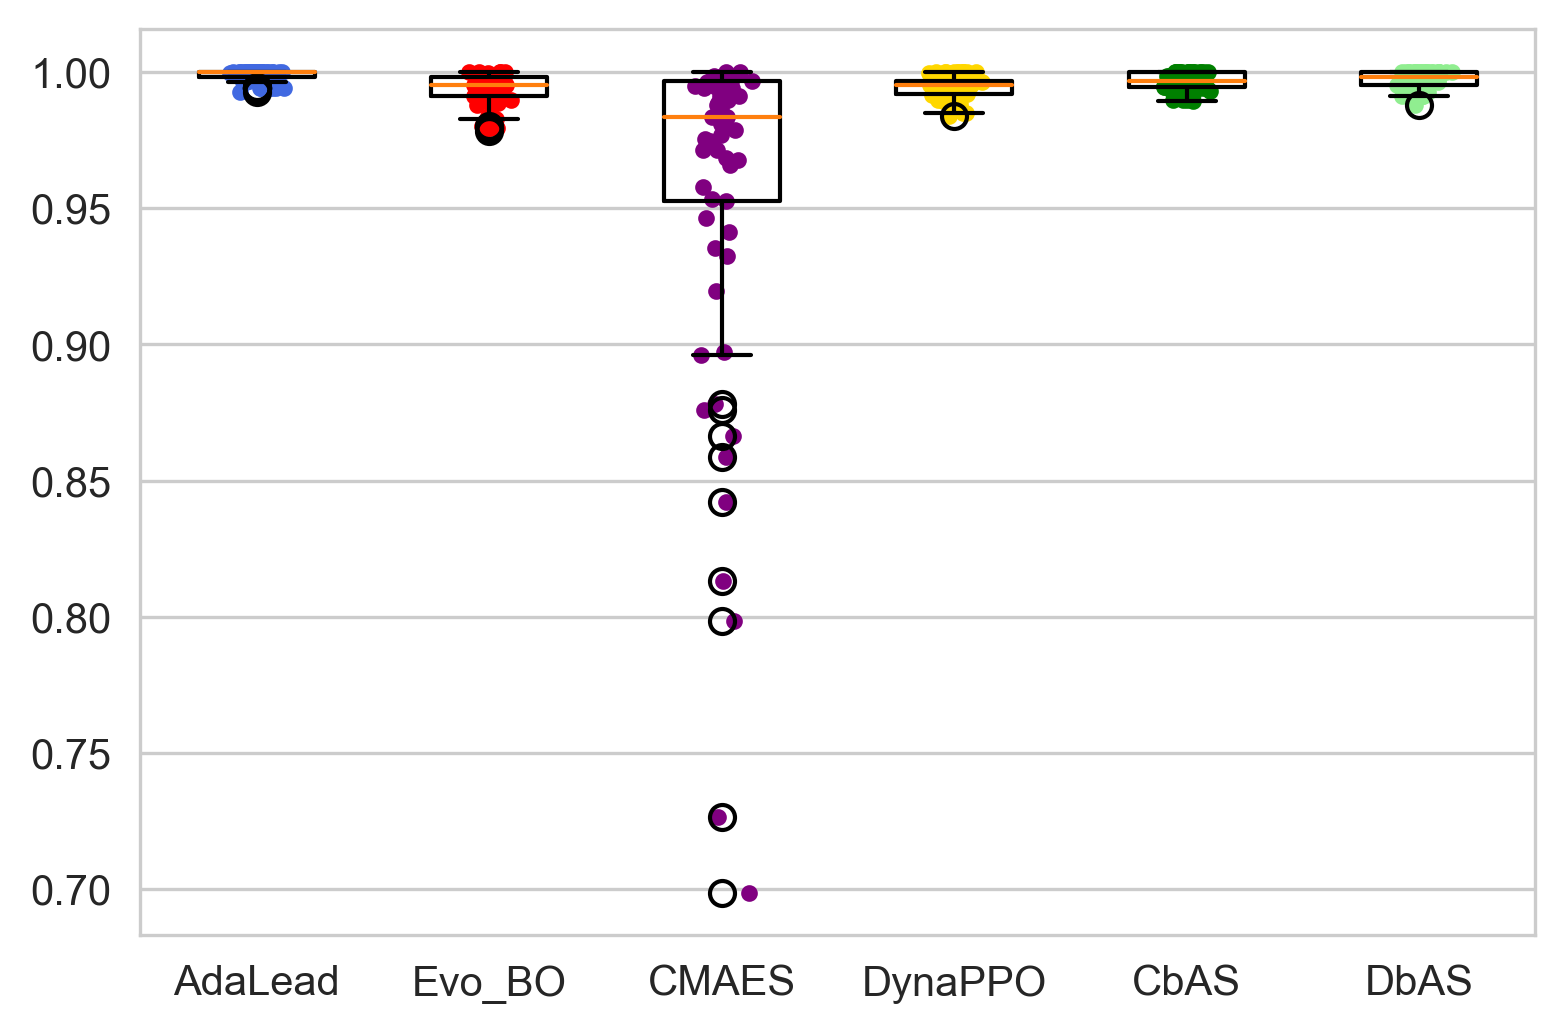

In [7]:
def jitter(x, size):
    return x + .05 * np.random.randn(size)

adalead_res = get_maxes('../../paper_data_9_30/figure2a/adalead/*')
bo_res = get_maxes('../../paper_data_9_30/figure2a/bo/*')
cmaes_res = get_maxes('../../paper_data_9_30/figure2a/cmaes/*')
dynappo_res = get_maxes('../../paper_data_9_30/figure2a/dynappo/*')
cbas_res = get_maxes('../../paper_data_9_30/figure2a/cbas/*')
dbas_res = get_maxes('../../paper_data_9_30/figure2a/dbas/*')

data = [adalead_res, bo_res, cmaes_res, dynappo_res, cbas_res, dbas_res]
names = ['AdaLead', 'Evo_BO', 'CMAES', 'DynaPPO', 'CbAS', 'DbAS']

plt.figure(dpi=300)
sns.set_style('whitegrid')
plt.grid(b=None, axis='x')
plt.boxplot(data, labels=names)
for i, (name, d) in enumerate(zip(names, data)):
    plt.scatter(jitter(i + 1, len(d)), d, c=palette[name], marker='.')
plt.show()

## Figure 2B

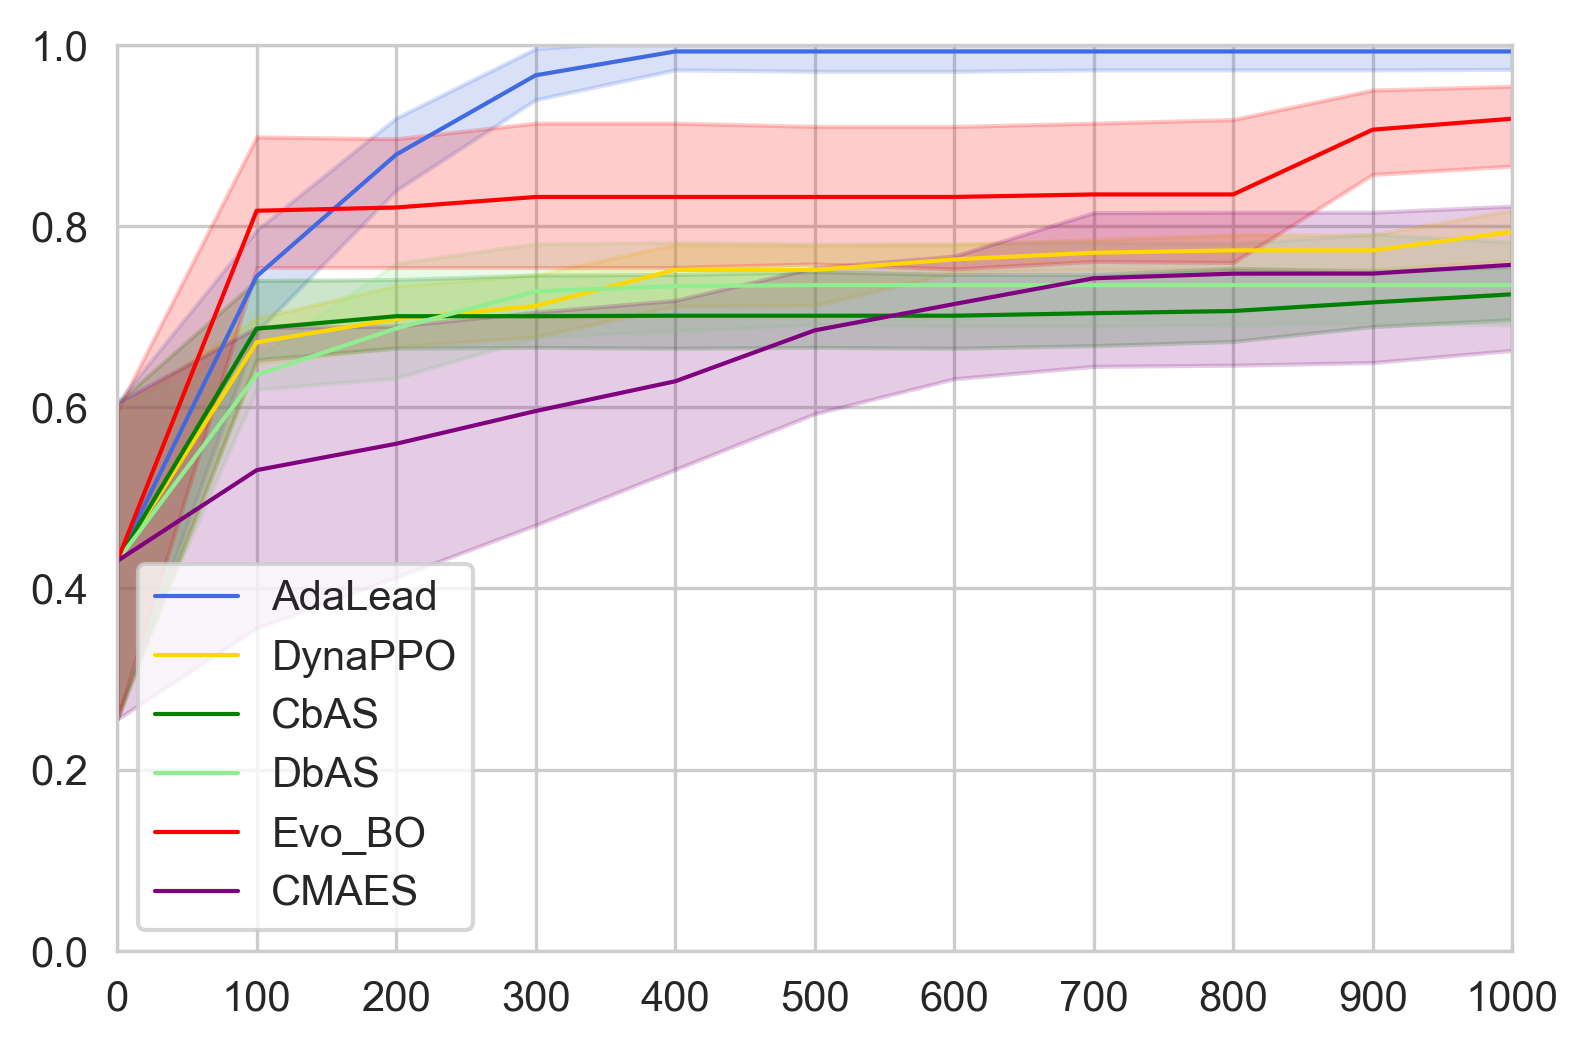

In [5]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/L14_RNA1+2_start*_ss1.0'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(np.arange(len(max_per_round)) * 100)
    
    return measurements, 0.98 * np.array(scores)

names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    sns.lineplot(*compute_scores(run_dir), label=name, color=palette[name], linewidth=1)
plt.xticks(range(0, 1001, 100))
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.legend()
plt.show()

## Figure 2C

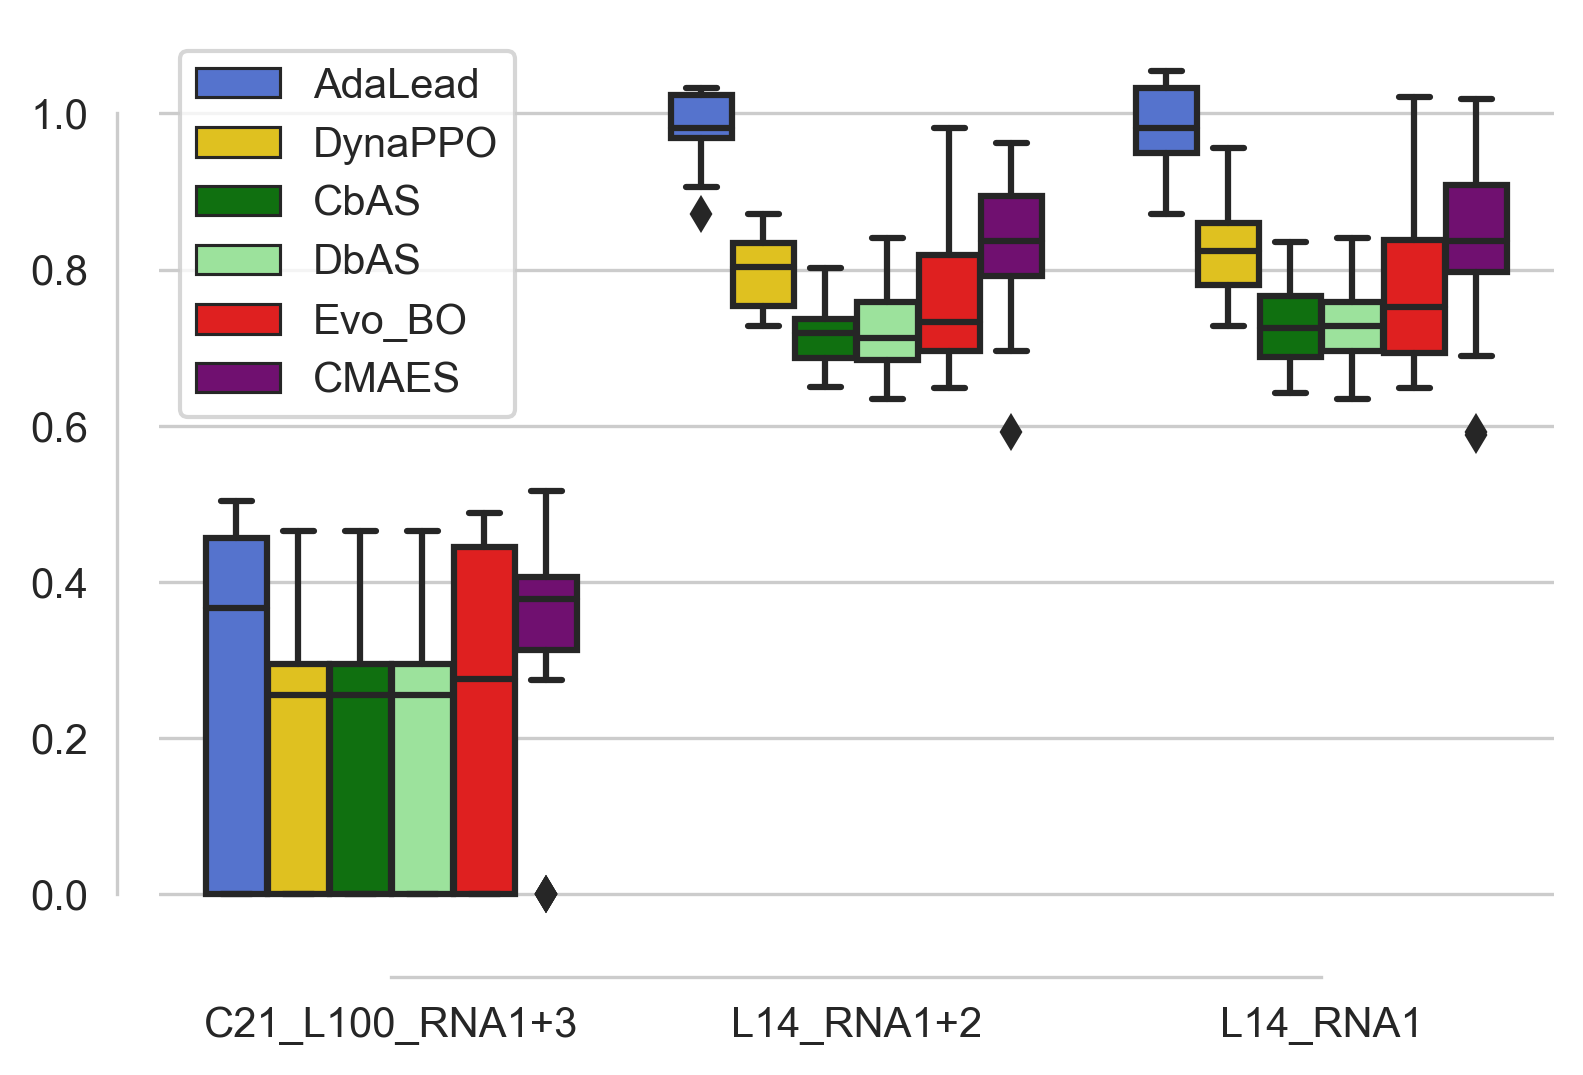

In [45]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

data = {
    'landscape': [],
    'algo': [],
    'maxes': []
}
for i, landscape in enumerate(['C21_L100_RNA1+3', 'L14_RNA1+2', 'L14_RNA1']):
    for name, run_dir in names_and_dirs.items():
        for m in get_maxes(f'{run_dir}/{landscape}*ss*'):
            data['landscape'].append(landscape)
            data['algo'].append(name)
            data['maxes'].append(m)

sns.boxplot(x='landscape', y='maxes', hue='algo', palette=palette, data=data)
sns.despine(offset=10, trim=True)

plt.legend()
plt.show()

## Figure 2D

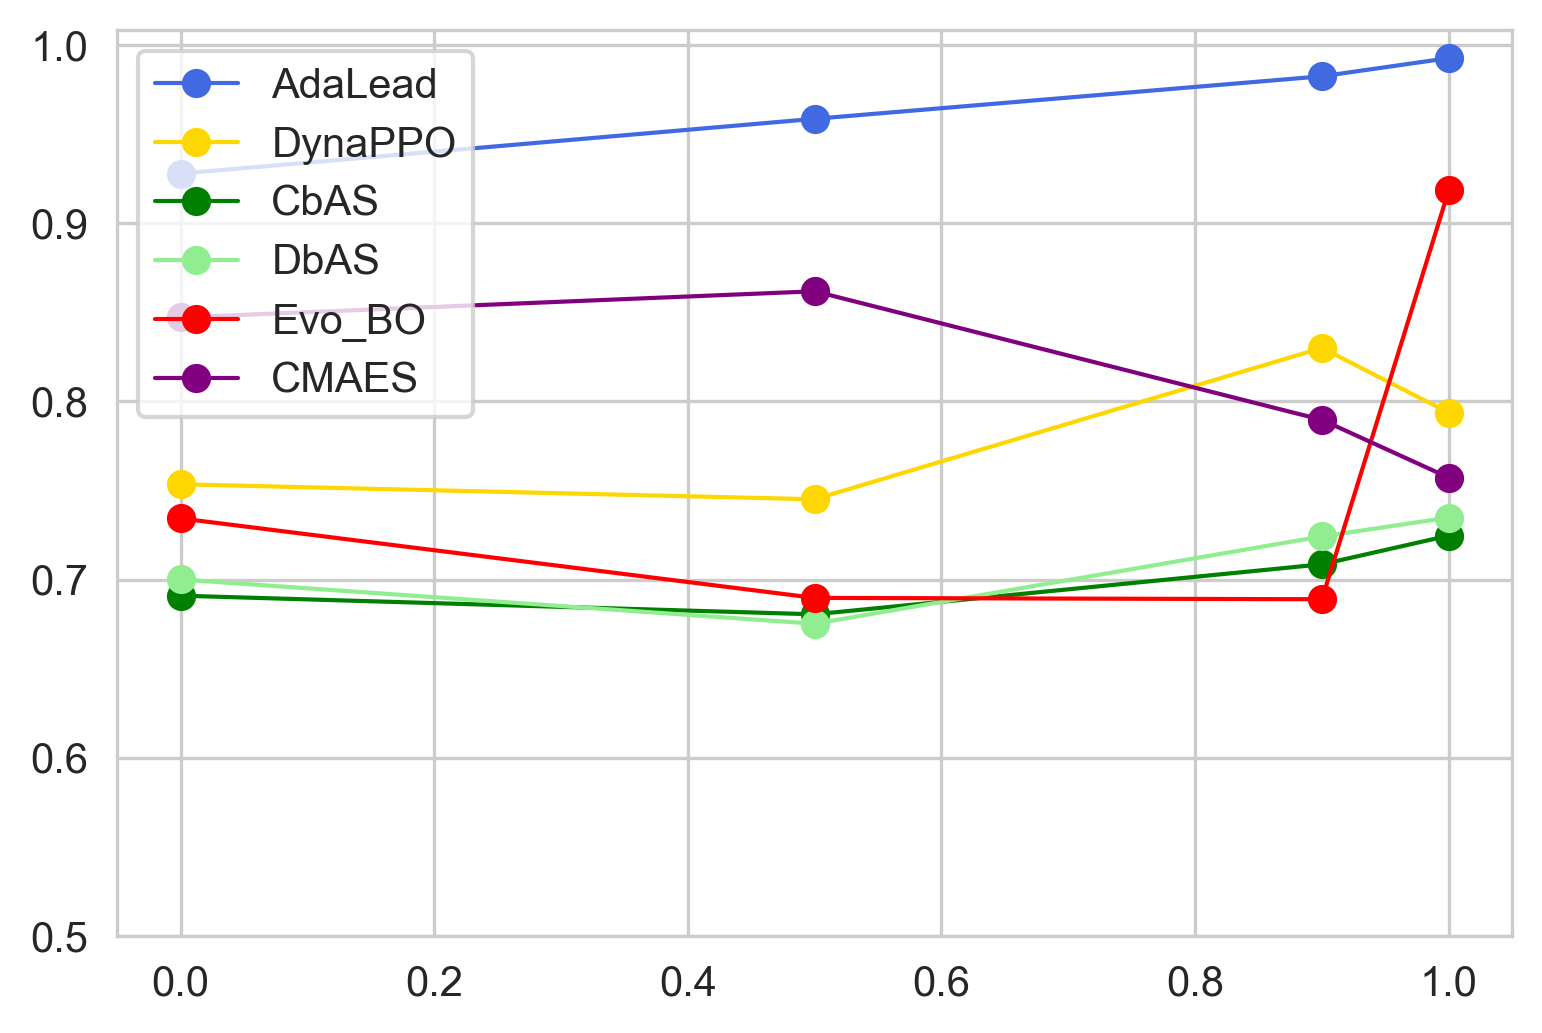

In [29]:
names_and_dirs = {
    'AdaLead': '../../paper_data_9_30/table1/adalead',
    'DynaPPO': '../../paper_data_9_30/table1/dynappo',
    'CbAS': '../../paper_data_9_30/table1/cbas',
    'DbAS': '../../paper_data_9_30/table1/dbas',
    'Evo_BO': '../../paper_data_9_30/table1/bo',
    'CMAES': '../../paper_data_9_30/table1/cmaes',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')

for name, run_dir in names_and_dirs.items():
    ss_mean_maxes = [0.98 * np.mean(get_maxes(f'{run_dir}/L14_RNA1+2_start*_ss{ss}'))
                     for ss in ['0.0', '0.5', '0.9', '1.0']]
    
    plt.plot([0, 0.5, 0.9, 1], ss_mean_maxes, '-o', label=name, color=palette[name], linewidth=1)

plt.ylim(0.5)
plt.legend()
plt.show()

## Rosetta Plot

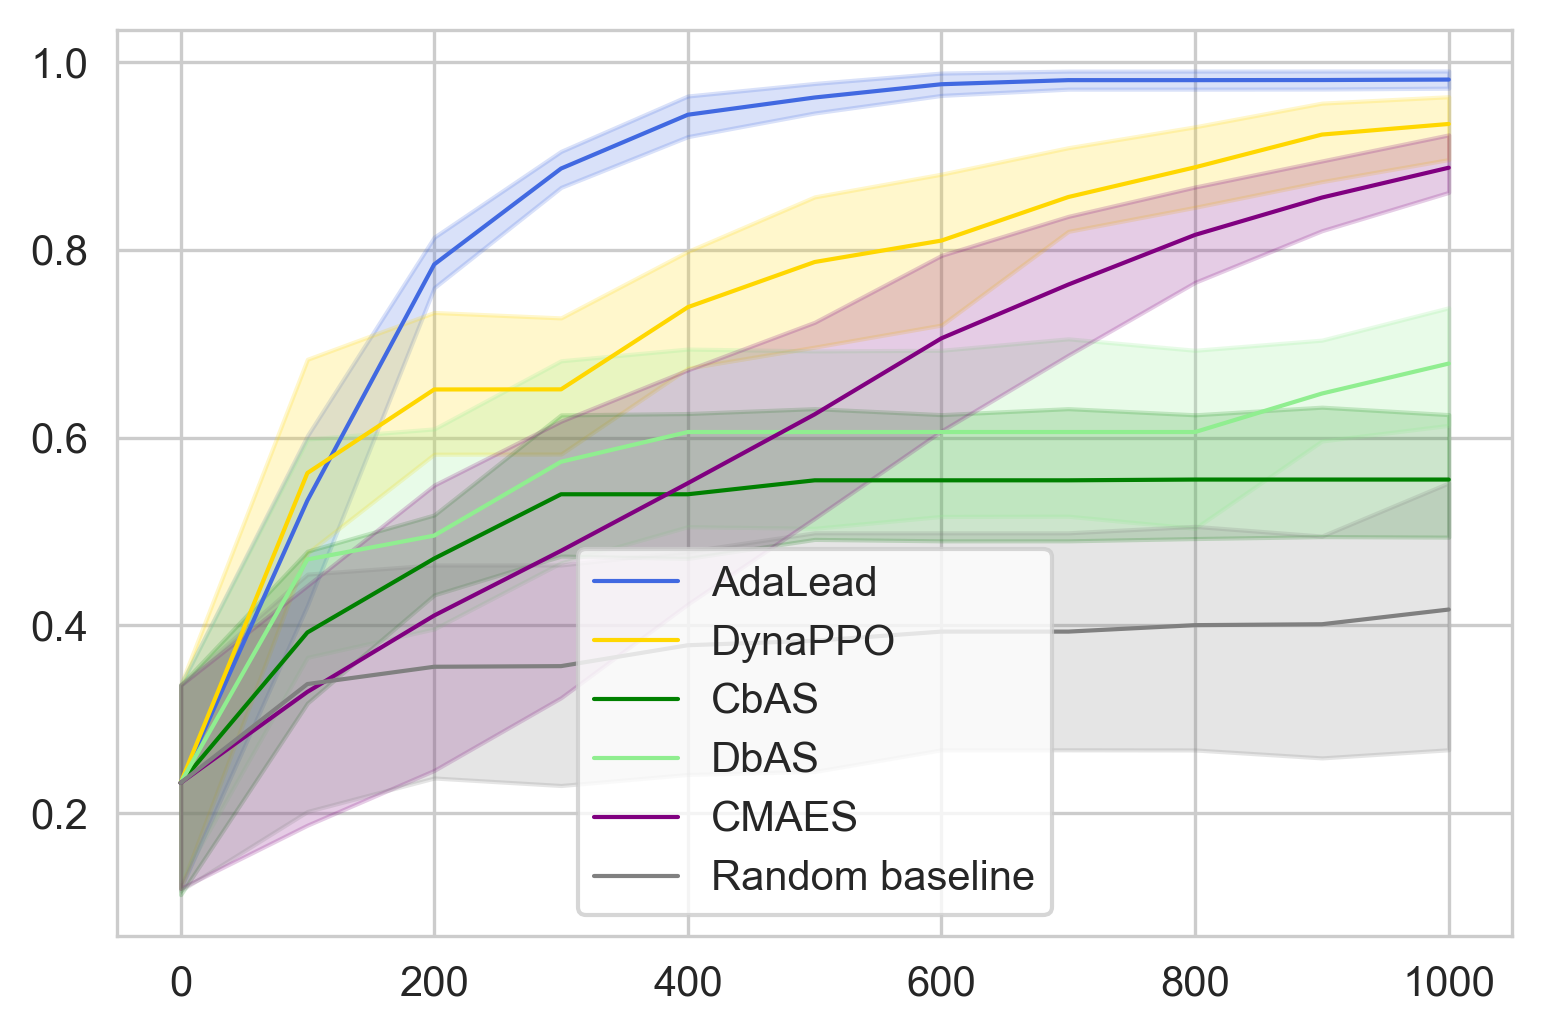

In [47]:
def cumulative_max_per_round(sequences):
    num_rounds = sequences['round'].max() + 1
    max_per_round = [sequences['true_score'][sequences['round'] == r].max()
                     for r in range(num_rounds)]
    return np.maximum.accumulate(max_per_round)

def compute_scores(run_dir):
    measurements = []
    scores = []
    for fname in glob.glob(f'{run_dir}/*'):
        # Skip metadata in header
        with open(fname) as f:
            next(f)
            df = pd.read_csv(f)

        max_per_round = cumulative_max_per_round(df)
        scores.extend(max_per_round)
        measurements.extend(np.arange(len(max_per_round)) * 100)
    
    return measurements, scores

names_and_dirs = {
    'AdaLead': '../cloud/runs/3msi/adalead',
    'DynaPPO': '../cloud/runs/3msi/dynappo',
    'CbAS': '../cloud/runs/3msi/cbas',
    'DbAS': '../cloud/runs/3msi/dbas',
    'CMAES': '../cloud/runs/3msi/cmaes',
    'Evo_BO': '../cloud/runs/3msi/bo',
    'Random baseline': '../cloud/runs/3msi/random',
}

plt.figure(dpi=300)
sns.set_style('whitegrid')
for name, run_dir in names_and_dirs.items():
    sns.lineplot(*compute_scores(run_dir), label=name, color=palette[name], linewidth=1)
plt.legend()
plt.show()